## Load Library

In [1]:
import os
import re
import time
import gzip
import faiss
import string
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from typing import List
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize as tokenize
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report,confusion_matrix

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

/Users/h0s060n/Documents/anaconda3/envs/sem_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
# STEP 1 - DOWNLOAD DATA FROM ( http://jmcauley.ucsd.edu/data/amazon/ )
# For this semantic search classification we have taken 4 categories

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

cat1_baby = getDF('./data/reviews_Baby_5.json.gz')
cat2_beauty = getDF('./data/reviews_Beauty_5.json.gz')
cat3_grocery=getDF('./data/reviews_Grocery_and_Gourmet_Food_5.json.gz')
cat4_music=getDF('./data/reviews_Musical_Instruments_5.json.gz')

# create category column for each file (dataframe)
cat1_baby["category"]="baby"
cat2_beauty["category"]="beauty"
cat3_grocery["category"]="grocery"
cat4_music["category"]="music"

In [4]:
cat1_baby.head(2)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,category
0,A1HK2FQW6KXQB2,097293751X,"Amanda Johnsen ""Amanda E. Johnsen""","[0, 0]",Perfect for new parents. We were able to keep ...,5.0,Awesine,1373932800,"07 16, 2013",baby
1,A19K65VY14D13R,097293751X,angela,"[0, 0]",This book is such a life saver. It has been s...,5.0,Should be required for all new parents!,1372464000,"06 29, 2013",baby


## Take Uneven Samples

In [4]:
## randomly take few samples from each dataframe and just to test mis-imblanced scenario we have taken uneven numbers
cat1_baby=cat1_baby[["reviewText","category"]].sample(900)
cat2_beauty=cat2_beauty[["reviewText","category"]].sample(1200)
cat3_grocery=cat3_grocery[["reviewText","category"]].sample(1500)
cat4_music=cat4_music[["reviewText","category"]].sample(3000)
df = pd.concat([cat1_baby,cat2_beauty,cat3_grocery,cat4_music],axis=0).reset_index()[["reviewText","category"]]

In [106]:
print("Total Data",len(df))

Total Data 6600


In [6]:
df.head(2)

,reviewText,category
0,"I've been using this on a newborn, so it's bul...",baby
1,This changing pad cover works great on the Esp...,baby


## Clean the dataframe 

In [7]:
stop_words=stopwords.words('english')
def clean(text):
    text=text.lower()
    url_removed=re.sub(r'https\S+','',text,flags=re.MULTILINE)
    text=re.sub("[^a-zA-Z]"," ",url_removed)
    text=re.sub("\.+"," ",text)
    word_tokens=tokenize(text)
    text=[word for word in word_tokens if word  not in stop_words]
    text=[word for word in text if word not in string.punctuation]
    return " ".join(text)

# df["cleaned_review_data"]=df["reviewText"].apply(lambda x:clean(x))
# df["category"].dropna(inplace=True)
# df.drop_duplicates(inplace=True)

clean("This is  good day . ! ! , I IS  #")

'good day'

In [12]:
len(df)

6599

## Split the Dataframe to train test split

In [13]:
train,test= train_test_split(df,stratify=df[["category"]],test_size=0.2)
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [15]:
train['category'].value_counts()

music      2399
grocery    1200
beauty      960
baby        720
Name: category, dtype: int64

In [16]:
train

,reviewText,category,cleaned_review_data
0,"Very pleased with the product, holds better th...",beauty,pleased product holds better size larger expec...
1,It's comfortable. It's adjustable. The color w...,music,comfortable adjustable color good match guitar...
2,It seems to leave your skin softer than anythi...,beauty,seems leave skin softer anything else used pur...
3,Quinoa is All Protein it is Very Health Benefi...,grocery,quinoa protein health beneficial take time loo...
4,The only real reason that I didn't give it 5 s...,baby,real reason give stars sure forks stage yet su...
...,...,...,...
5274,"This chocolate was a bit less sweet, more bitt...",grocery,chocolate bit less sweet bitter harder usually...
5275,I ended up ordering this cable to connect my b...,music,ended ordering cable connect bottom row effect...
5276,"For most of my life, my hair was bone straight...",beauty,life hair bone straight result know care strai...
5277,I bought this set mainly because I wanted a ch...,music,bought set mainly wanted cheap micro fiber clo...


# save the train and test to csv file for future use

In [17]:
train.to_csv("train_data.csv",index=False)
test.to_csv("test_data.csv",index=False)

## Create Embeddings for train and create mappings

In [10]:
model=SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
train_cleaned_texts = train["cleaned_review_data"].tolist()
train_cleaned_texts = list(map(str, train_cleaned_texts))


def get_embeddings(model, sentences: List[str], parallel: bool = True):
    start = time.time()
    if parallel:
        # Start the multi-process pool on all cores
        os.environ["TOKENIZERS_PARALLELISM"] = "false"
        pool = model.start_multi_process_pool(target_devices=["cpu"] * 5)
        embeddings = model.encode_multi_process(sentences, pool, batch_size=16)
        model.stop_multi_process_pool(pool)
    else:
        os.environ["TOKENIZERS_PARALLELISM"] = "true"
        embeddings = model.encode(
            sentences,
            batch_size=32,
            show_progress_bar=True,
            convert_to_tensor=True,
        )
    print(f"Time taken to encode {len(sentences)} items: {round(time.time() - start, 2)}")
    return embeddings.detach().numpy()

train_embeddings = get_embeddings(model=model, sentences=train_cleaned_texts, parallel=False)
print(train_embeddings.shape)

#save embeddings of idea texts
cleaned_train_texts_embeddings_file = f"./data/train_embeddings_all_minilm_l6_v2.pkl"
pickle.dump(train_embeddings, open(cleaned_train_texts_embeddings_file, "wb"))


#create mappings for index and category this will be later used for faiss
train_category_index_mapping=dict(zip(train.index,train.category))
with open('./data/train_category_index.pickle', 'wb') as handle:
    pickle.dump(train_category_index_mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Create Index 

In [4]:
#load the mappings file which is used for printing category as output
def get_mappings(file_name):
    with open(file_name, 'rb') as handle:
        category_mapping_dict = pickle.load(handle)
    return category_mapping_dict

#read the embeddings created at earlier step
def read_embeddings(file_name):
    cleaned_texts_embeddings_file = file_name
    if os.path.exists(cleaned_texts_embeddings_file):
        with open(cleaned_texts_embeddings_file, "rb") as f:
            embeddings = pickle.load(f)
    temp1=np.asarray(embeddings,dtype="float32")
    return temp1

#save the index once its created
def save_index(index):
    path = os.path.join("./data/","review_category_train_index")
    faiss.write_index(index, path)

# we have used flat Index and with Inner product
def create_index(mappings,samples):
    index = faiss.IndexIDMap(faiss.IndexFlatIP(samples.shape[1]))
    faiss.normalize_L2(samples)  # normalise the embedding
    #index.train(samples)
    index.add_with_ids(samples,np.array(list(mappings.keys())))
    save_index(index)
    return

## call the above functions

In [5]:
mappings = get_mappings(file_name='./data/train_category_index.pickle')
samples = read_embeddings(file_name=f"./data/train_embeddings_all_minilm_l6_v2.pkl")
create_index(mappings=mappings,samples=samples)

In [8]:
# print top 2 categories among top5 nearest neighbours returned from index search
train=pd.read_csv("./data/train_data.csv") # using the file from previous notebook created step
test=pd.read_csv("./data/test_data.csv")
def most_frequent(result):
    top2 = Counter(result)
    return top2.most_common(2)


#read the index
index = faiss.read_index("./data/review_category_train_index")

# embeddings for query
def predict_embeddings(query):
    query_embedding=model.encode(query)
    query_embedding=np.asarray([query_embedding],dtype="float32")
    return query_embedding
    

#predict for given query
def predict(query,mappings):
    cleaned_query= clean(query)
    query_embedding=predict_embeddings(cleaned_query)
    faiss.normalize_L2(query_embedding)
    D, I = index.search(query_embedding, 5) # d is the distance and I is the index number 
    for values in I:
        for distance in D:
            details= {'cleaned_text':train.iloc[values]["reviewText"],
            'category':train.iloc[values]["category"],
            'score':distance
            }
            print("===============================================")
            print(pd.DataFrame(details))
            print("===============================================")
    return most_frequent([mappings[id_] for id_ in I[0]])


In [11]:
predict(query="tune your groove",mappings=mappings)

                                                                                                                                                                                                                               cleaned_text  \
2337                                                          Excellent little device for the money.  Easy to use.  I have paid double for tuners that have not worked as well.  This will get you in tune for $11 or less - can't beat it.   
3545                                            I bought this tuner because I am learning to play guitar and want to keep my guitar in tuneGreat little tuner that looks good and works even better It works really well, but not perfectly   
2504  This little tuner is so easy to use and see...I bought two more as presents. The price point was just unbeatable for such a stellar performing tuner. If you don't have a tuner or are looking for a new one, you NEED this one. A+++   
2511                                        

[('music', 5)]

In [12]:
predict(query="quinoa",mappings=mappings)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     cleaned_text  \
247                                                                                                                                                                                

[('grocery', 5)]

## Predict function for test data

In [13]:
def most_frequent_test(result):
    top2 = Counter(result)
    return top2.most_common(1)


def test_predict(query,mappings=mappings):
    cleaned_query= clean(query)
    query_embedding=predict_embeddings(cleaned_query)
    faiss.normalize_L2(query_embedding)
    D, I = index.search(query_embedding, 5) # d is the distance and I is the index number 
    return most_frequent([mappings[id_] for id_ in I[0]])[0][0]


test["predict"]=test["reviewText"].apply(lambda x:test_predict(x))

In [15]:
start=time.time()
print(test_predict("quionoa",mappings),time.time()-start)

grocery 0.020138025283813477


In [94]:
test.head(2)

,reviewText,category,cleaned_review_data,predict
0,"It's noisy, but if you find out how to equalize the tone and volume, it works fine. I bought it cause Gilmour uses this effect but certainly the one he uses must be of a much more better quality product.",music,noisy find equalize tone volume works fine bought cause gilmour uses effect certainly one uses must much better quality product,music
1,With some trials using different tubes this pedal can add something that is very tough to get otherwise. I run my guitar direct because I don't like amps or having to cart the things around. There are so many shades of tone available that it's tough to really praise this gadget enough especially considering the low cost. I also found using a compresser before it helps. I have a Pigtronix Philosopher's Tone & it made a big differrence. I highly reccomend this tube pre-amp & encourage trying out different tubes to get the sound you want.,music,trials using different tubes pedal add something tough get otherwise run guitar direct like amps cart things around many shades tone available tough really praise gadget enough especially considering low cost also found using compresser helps pigtronix philosopher tone made big differrence highly reccomend tube pre amp encourage trying different tubes get sound want,music


## Classification Report for test file

In [97]:
print(classification_report(test['category'],test["predict"]))
cm = confusion_matrix(test['category'],test["predict"])

              precision    recall  f1-score   support

        baby       0.95      0.91      0.93       180
      beauty       0.92      0.95      0.94       240
     grocery       0.99      0.98      0.98       300
       music       0.97      0.98      0.97       600

    accuracy                           0.96      1320
   macro avg       0.96      0.95      0.96      1320
weighted avg       0.96      0.96      0.96      1320



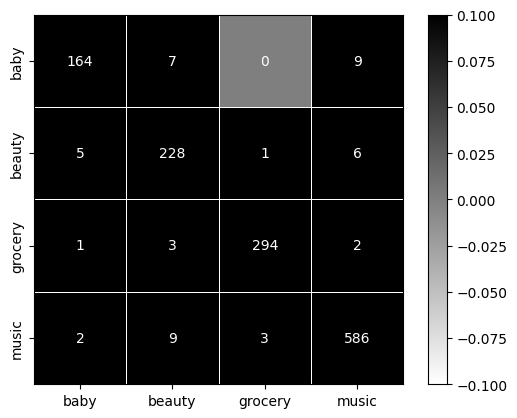

In [98]:
labels = ['baby','beauty','grocery','music']
sns.heatmap(cm, fmt='d', annot=True, square=True,
            cmap='gray_r', vmin=0, vmax=0,  # set all to white
            linewidths=0.5, linecolor='w',  # draw black grid lines
            xticklabels=labels,yticklabels=labels)                     # disable colorbar

# re-enable outer spines
sns.despine(left=False, right=False, top=False, bottom=False)

In [107]:
acc_score = accuracy_score(test['category'],test["predict"])
print("Test Accuracy Score",acc_score)

Test Accuracy Score 0.9636363636363636


#conclusion - misclassifications are happening on baby and music